# Surface currents in Wellington & Queens channel

In [1]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc

%matplotlib inline

Region to look at

In [3]:
imin, imax = 1480, 2050
jmin, jmax = 160, 800

In [4]:
mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
lons  = np.array(mesh.variables['nav_lon'])
lats  = np.array(mesh.variables['nav_lat'])

mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask.nc') #ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
umask = np.array(mask.variables['umask'])
vmask = np.array(mask.variables['vmask'])
land_mask = np.ma.masked_where((tmask[0,:,:,:] > 0.1), tmask[0,:,:,:])
tmask = tmask[0,:,imin:imax,jmin:jmax]
umask = umask[0,:,imin:imax,jmin:jmax]
vmask = vmask[0,:,imin:imax,jmin:jmax]

In [5]:
ref   = nc.Dataset('/data/brogalla/run_storage/trial4/ref-2002/ANHA12_EXH006_2002_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

Vector rotation:

In [6]:
def interp_np(nav_lon, nav_lat, var_in, gridx, gridy):
    ''' Interpolate ANHA4 variable onto Mercator (rectilinear) grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat: ANHA4 lons/lats
            gridx, gridy    : User defined lons/lats
            var_in          : 2-D ANHA4 variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (gridx, gridy), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (gridx, gridy), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

In [7]:
def find_inland(lon, lat, res='l'):
    '''
    Detect data points located in land
    Based on Basemap's GSHHS dataset.
    -------------------------------------------
    res = 'c' --> 'f'
    result = 1 --> land
           = 0 --> ocean/lake/river
    Designed for lon = [-180, 180]
    '''
    from matplotlib.path import Path
    result = np.empty(lon.shape)
    proj = Basemap(projection='cyl', resolution=res)
    for i in range(np.size(lon, 0)):
        x, y = proj(lon[i, :], lat[i, :])
        locations = np.c_[x, y]
        polygons = [Path(p.boundary) for p in proj.landpolygons]
        row_result = np.zeros(len(locations), dtype=bool) 
        for polygon in polygons:
            row_result += np.array(polygon.contains_points(locations))
        result[i, :] = row_result
    return result

In [8]:
ocean_x = np.linspace(-104, -83, 20)
ocean_y = np.linspace(73.5, 79, 20)
gridx, gridy = np.meshgrid(ocean_x, ocean_y)

June

In [15]:
# Load 5-day velocity file
folder2  = '/data/brogalla/ANHA12/'
file_u  = nc.Dataset(folder2 + 'ANHA12-EXH006_y2015m06d04_gridU.nc')
file_v  = nc.Dataset(folder2 + 'ANHA12-EXH006_y2015m06d04_gridV.nc')
u_vel   = np.array(file_u.variables['vozocrtx'])[0,0,1450:1780,350:600] 
v_vel   = np.array(file_v.variables['vomecrty'])[0,0,1450:1780,350:600] 

In [16]:
Ugrid = interp_np(lons[1450:1780,350:600], lats[1450:1780,350:600], u_vel, gridx, gridy)
Vgrid = interp_np(lons[1450:1780,350:600], lats[1450:1780,350:600], v_vel, gridx, gridy)

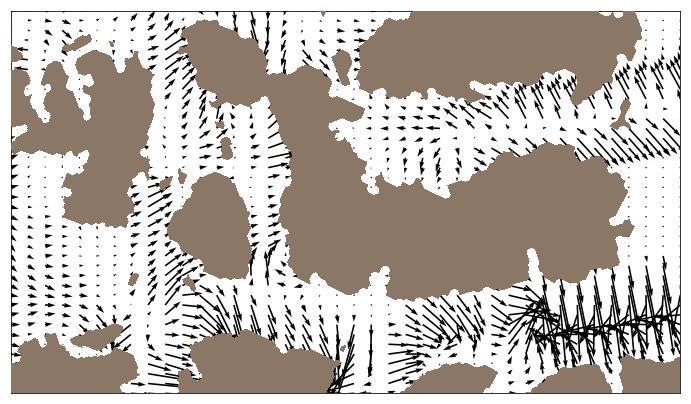

In [32]:
fig, ax1 = plt.subplots(figsize=(12,10))

proj2 = Basemap(projection='stere',lat_0 = 75.4, lon_0 = -90, resolution='i', width=0.7e6, height=0.4e6, ax=ax1)

x_land, y_land = proj2(lons, lats)
proj2.contourf(x_land[1450:1780,350:600], y_land[1450:1780,350:600], land_mask[0,1450:1780,350:600], \
               vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)

# Rotate vector
uproj, vproj = proj2.rotate_vector(Ugrid, Vgrid, gridx, gridy, returnxy=False)

# Interpolate, make u, v equally distributed in the map (optional)
uproj_rec, x, y = proj2.transform_scalar(uproj, ocean_x, ocean_y, 40, 40, returnxy=True)
vproj_rec, x, y = proj2.transform_scalar(vproj, ocean_x, ocean_y, 40, 40, returnxy=True)

proj2.quiver(x, y, uproj_rec, vproj_rec, zorder=2)

July:

In [23]:
# Load 5-day velocity file
folder2  = '/data/brogalla/ANHA12/'
file_u  = nc.Dataset(folder2 + 'ANHA12-EXH006_y2015m07d04_gridU.nc')
file_v  = nc.Dataset(folder2 + 'ANHA12-EXH006_y2015m07d04_gridV.nc')
u_vel   = np.array(file_u.variables['vozocrtx'])[0,0,1450:1780,350:600]
v_vel   = np.array(file_v.variables['vomecrty'])[0,0,1450:1780,350:600]

In [24]:
Ugrid = interp_np(lons[1450:1780,350:600], lats[1450:1780,350:600], u_vel, gridx, gridy)
Vgrid = interp_np(lons[1450:1780,350:600], lats[1450:1780,350:600], v_vel, gridx, gridy)

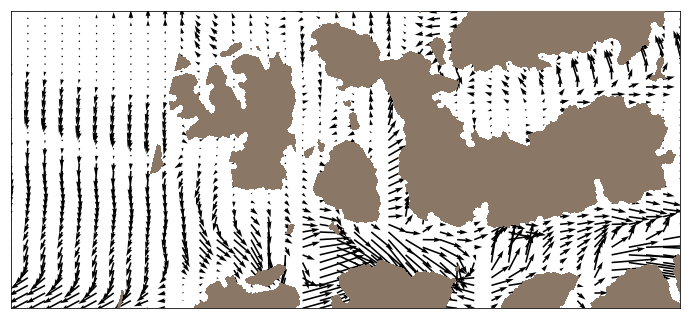

In [25]:
fig, ax1 = plt.subplots(figsize=(12,10))

proj2 = Basemap(projection='stere',lat_0 = 75.4, lon_0 = -95, resolution='i', width=0.9e6, height=0.4e6, ax=ax1)

x_land, y_land = proj2(lons, lats)
proj2.contourf(x_land[1450:1780,350:600], y_land[1450:1780,350:600], land_mask[0,1450:1780,350:600], \
               vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)

# Rotate vector
uproj, vproj = proj2.rotate_vector(Ugrid, Vgrid, gridx, gridy, returnxy=False)

# Interpolate, make u, v equally distributed in the map (optional)
uproj_rec, x, y = proj2.transform_scalar(uproj, ocean_x, ocean_y, 40, 40, returnxy=True)
vproj_rec, x, y = proj2.transform_scalar(vproj, ocean_x, ocean_y, 40, 40, returnxy=True)

proj2.quiver(x, y, uproj_rec, vproj_rec, zorder=2)

August:

In [26]:
# Load 5-day velocity file
folder2  = '/data/brogalla/ANHA12/'
file_u  = nc.Dataset(folder2 + 'ANHA12-EXH006_y2015m08d03_gridU.nc')
file_v  = nc.Dataset(folder2 + 'ANHA12-EXH006_y2015m08d03_gridV.nc')
u_vel   = np.array(file_u.variables['vozocrtx'])[0,0,1450:1780,350:600] 
v_vel   = np.array(file_v.variables['vomecrty'])[0,0,1450:1780,350:600] 

In [27]:
Ugrid = interp_np(lons[1450:1780,350:600], lats[1450:1780,350:600], u_vel, gridx, gridy)
Vgrid = interp_np(lons[1450:1780,350:600], lats[1450:1780,350:600], v_vel, gridx, gridy)

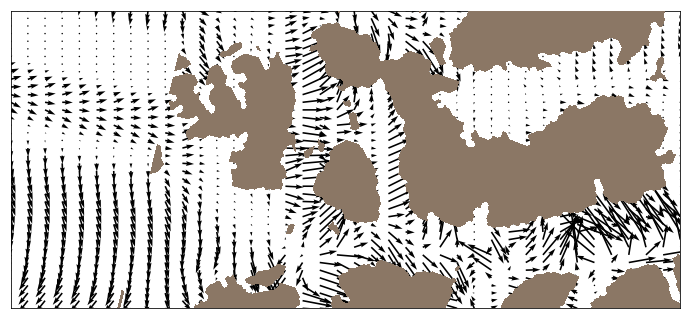

In [28]:
fig, ax1 = plt.subplots(figsize=(12,10))

proj2 = Basemap(projection='stere',lat_0 = 75.4, lon_0 = -95, resolution='i', width=0.9e6, height=0.4e6, ax=ax1)

x_land, y_land = proj2(lons, lats)
proj2.contourf(x_land[1450:1780,350:600], y_land[1450:1780,350:600], land_mask[0,1450:1780,350:600], \
               vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)

# Rotate vector
uproj, vproj = proj2.rotate_vector(Ugrid, Vgrid, gridx, gridy, returnxy=False)

# Interpolate, make u, v equally distributed in the map (optional)
uproj_rec, x, y = proj2.transform_scalar(uproj, ocean_x, ocean_y, 40, 40, returnxy=True)
vproj_rec, x, y = proj2.transform_scalar(vproj, ocean_x, ocean_y, 40, 40, returnxy=True)

proj2.quiver(x, y, uproj_rec, vproj_rec, zorder=2)

September

In [29]:
# Load 5-day velocity file
folder2  = '/data/brogalla/ANHA12/'
file_u  = nc.Dataset(folder2 + 'ANHA12-EXH006_y2015m09d02_gridU.nc')
file_v  = nc.Dataset(folder2 + 'ANHA12-EXH006_y2015m09d02_gridV.nc')
u_vel   = np.array(file_u.variables['vozocrtx'])[0,0,1450:1780,350:600] 
v_vel   = np.array(file_v.variables['vomecrty'])[0,0,1450:1780,350:600] 

In [30]:
Ugrid = interp_np(lons[1450:1780,350:600], lats[1450:1780,350:600], u_vel, gridx, gridy)
Vgrid = interp_np(lons[1450:1780,350:600], lats[1450:1780,350:600], v_vel, gridx, gridy)

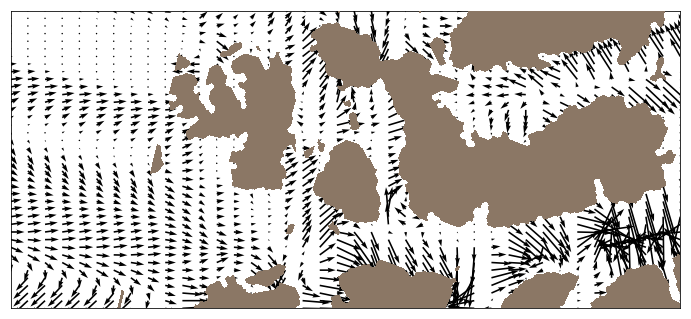

In [31]:
fig, ax1 = plt.subplots(figsize=(12,10))

proj2 = Basemap(projection='stere',lat_0 = 75.4, lon_0 = -95, resolution='i', width=0.9e6, height=0.4e6, ax=ax1)

x_land, y_land = proj2(lons, lats)
proj2.contourf(x_land[1450:1780,350:600], y_land[1450:1780,350:600], land_mask[0,1450:1780,350:600], \
               vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)

# Rotate vector
uproj, vproj = proj2.rotate_vector(Ugrid, Vgrid, gridx, gridy, returnxy=False)

# Interpolate, make u, v equally distributed in the map (optional)
uproj_rec, x, y = proj2.transform_scalar(uproj, ocean_x, ocean_y, 40, 40, returnxy=True)
vproj_rec, x, y = proj2.transform_scalar(vproj, ocean_x, ocean_y, 40, 40, returnxy=True)

proj2.quiver(x, y, uproj_rec, vproj_rec, zorder=2)